In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
import pickle

# Func & Load

In [6]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        # meta = meta.head(1) # multisession, only keep one metadata
    return meta

In [14]:
root_path = r'C:\Users\GlickfeldLab\Documents\test\inter/'.replace('\\', '/')
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
print(meta)

meta = meta.iloc[3].to_frame().T.reset_index()
meta

   mouse           date area  num
0   1350  211222_caiman   V1  2.0
1   1350  211222_caiman   V1  3.0
2   1350  211222_caiman   V1  4.0
3   1350  220124_caiman   LM  2.0
4   1350  220124_caiman   LM  3.0


,index,mouse,date,area,num
0,3,1350,220124_caiman,LM,2.0


In [29]:
# root_path = 'C:/Users/ll357/Documents/inter/'
# meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
# print(meta)

dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'resp_base_trialwise' + '.mat'))
print(dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape)

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] # do not subtract baseline here: stim resp will be compared to base resp
dfof_tg_trial = dfof_trialwise['dfof_tg_trial']

(516, 30) (51, 1)


# One way anova
for each cell, base = [ntrial, 1], stim_resp = [ntrial_stim, nstim].  
base vs stim anova or kruskal wallis

In [30]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]

p_anova = np.ones((ncell, 1)) * np.nan
p_kruskal = np.ones((ncell, 1)) * np.nan
# p_alexandergovern = np.ones((ncell, 1)) * np.nan

for icell in tqdm(np.arange(ncell)):
    base_cell = np.concatenate([dfof_trialwise['dfof_base_trial'][icell, stim] for stim in range(nstim)])
    stim_cell = [] 
    for istim in np.arange(nstim):
        stim_cell.append(np.array(dfof_ad_trial[icell, istim]).flatten())
    
    _, p_anova_cell = stats.f_oneway(np.array(base_cell).flatten(), *stim_cell)
    p_anova[icell] = p_anova_cell
    _, p_kruskal_cell = stats.kruskal(np.array(base_cell).flatten(), *stim_cell)
    p_kruskal[icell] = p_kruskal_cell
    # _, p_alexandergovern_cell = stats.alexandergovern(np.array(base_cell).flatten(), *stim_cell)
    # p_alexandergovern[icell] = p_alexandergovern_cell
    # print(stats.alexandergovern(np.array(base_cell).flatten(), *stim_cell)) # alexandergovern result cannot extract p-value

100%|██████████| 516/516 [00:02<00:00, 246.01it/s]


(array([310]), array([355]))

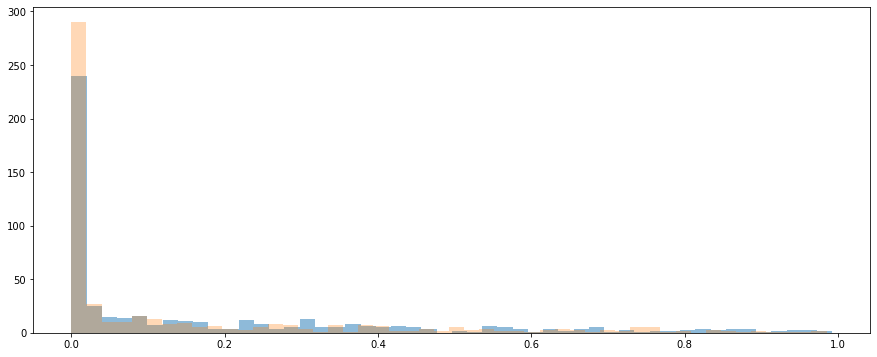

In [38]:
plt.figure(figsize=(15,6))
plt.hist(p_anova, 50, alpha=0.5);
plt.hist(p_kruskal, 50, alpha=0.3);
sum(p_anova < 0.1), sum(p_kruskal < 0.1)

# One sided t test
for each cell, base = [ntrial_stim, 1], stim_resp = [ntrial_stim, nstim].  
base vs stim : 1 sided t test

In [39]:
p_ttest = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    for istim in np.arange(nstim):
        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        
        _, p_ttest_i = stats.ttest_ind(base_cell.flatten(), stim_cell.flatten(), equal_var=False, alternative='less')
        p_ttest[icell, istim] = p_ttest_i

100%|██████████| 516/516 [00:06<00:00, 81.48it/s] 


In [45]:
print(0.05*ncell)
sum(p_ttest < 0.05)#.mean()

25.8


array([41, 41, 38, 23, 19, 55, 46, 59, 50, 14, 45, 35, 33, 33, 53, 38, 43,
       39, 52, 37, 44, 48, 36, 39, 41, 25, 55, 49, 31, 27])

In [46]:
# sum(p_ttest.T < 0.05)
(sum(p_ttest.T < 0.05) > 0).sum()

203

# Amp thresh
trial averaged stim resp > 10%

In [47]:
evoked = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    for istim in np.arange(nstim):
        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        
        evoked_cell = (stim_cell - base_cell) / (base_cell + 1e-7)
        evoked_i = np.mean(evoked_cell, axis=0) # trial averaged evoked resp
        evoked[icell, istim] = evoked_i

100%|██████████| 516/516 [00:00<00:00, 2158.47it/s]


In [48]:
evoked.shape, sum(evoked > 0.1), sum(evoked > 0.1).mean(), (sum(evoked.T > 0.1) > 0).sum()

((516, 30),
 array([159, 137, 151, 162, 136, 137, 143, 157, 127, 140, 154, 145, 145,
        149, 140, 163, 150, 130, 141, 143, 156, 143, 160, 166, 159, 152,
        151, 133, 150, 168]),
 148.23333333333332,
 516)

# AND gate
according to Ohki 2020  
anova -> visually driven cells,  
t test -> certain image responsive cells,  
amp thresh -> lower false positive rate

In [49]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]

p_anova = np.ones((ncell, 1)) * np.nan
p_kruskal = np.ones((ncell, 1)) * np.nan
p_ttest = np.ones((ncell, nstim)) * np.nan
evoked = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    base_cell_anova = np.concatenate([dfof_trialwise['dfof_base_trial'][icell, stim] for stim in range(nstim)])
    stim_cell_anova = [] 
    for istim in np.arange(nstim):
        stim_cell_anova.append(np.array(dfof_ad_trial[icell, istim]).flatten())

        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        _, p_ttest_i = stats.ttest_ind(base_cell.flatten(), stim_cell.flatten(), equal_var=False, alternative='less')
        p_ttest[icell, istim] = p_ttest_i

        evoked_cell = (stim_cell - base_cell) / (base_cell + 1e-7)
        evoked_i = np.mean(evoked_cell, axis=0) # trial averaged evoked resp
        evoked[icell, istim] = evoked_i
    
    _, p_anova_cell = stats.f_oneway(np.array(base_cell_anova).flatten(), *stim_cell_anova)
    p_anova[icell] = p_anova_cell
    _, p_kruskal_cell = stats.kruskal(np.array(base_cell_anova).flatten(), *stim_cell_anova)
    p_kruskal[icell] = p_kruskal_cell

100%|██████████| 516/516 [00:08<00:00, 57.88it/s]


In [52]:
# visually driven cells: pass (anova OR kruskal) AND amp threshold for >=1 image
p_sig = 0.1
vis_driven = ((p_anova < p_sig) | (p_kruskal < p_sig)) & (sum(evoked.T > 0.1) > 0).reshape(-1, 1)
print(f'{vis_driven.sum()} cells are visually driven, \n\
    proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

# cells responsive to image i: pass visually driven (anova OR kruskal) AND t-test AND amp threshold for *this* image
img_driven = vis_driven & (p_ttest < p_sig) & (evoked > 0.1)
print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
    proportion {np.round(img_driven.sum() / (ncell*nstim), 2)} out of {ncell*nstim} cell-stim combos. \n\
    1-30 image evokes resp from {np.sum(img_driven, axis=0)} cells')

t = np.sum(img_driven, axis=1)
print(f'img driven cells are driven by {t[t>0]} images')

380 cells are visually driven, 
    proportion 0.74 out of 516 cells
432 cells are image driven - with overlap between images, 
    proportion 0.03 out of 15480 cell-stim combos. 
    1-30 image evokes resp from [20  8 11 10  5 10 15 24 17  7 17 10 10 13 21 18 16 12 17 13 14 16 19 13
 16 15 20 23 11 11] cells
img driven cells are driven by [ 1  1  5  2  4  1  1  6  2  4  5  3  5  4 11  3  5  4  5 10  3  1  2  5
  1  2  1  4  5  5  6  1  5  4  1  2  1  5  8  4  5  9  3  4  2  4  2  2
  1  1  5  2  2  4  1  5  4  4  1  8  3  2  3  4  4  3  3  4  9  1  5  4
  1  4  3  5  1  7  4  1  3  1  4  2  1  6  5  8  3  5  1  1  1  1  1  1
  1  2  3  2  1  6  3  1  4  1  1  1  2  2  3  5  2  1  2  1  4  5  1  1
  2  1  1  1  1  7  2  3  2 10  9  2  4] images


In [248]:
# print(os.getcwd())
# with open('vis_img_driven_test_sig.pickle', 'wb') as handle:
#     pickle.dump(p_anova, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(p_kruskal, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(evoked, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(p_ttest, handle, protocol=pickle.HIGHEST_PROTOCOL)


c:\Users\ll357\Documents\inter\code\py_playground
